# Import Dataset
https://jmcauley.ucsd.edu/data/amazon/

In [1]:
import gzip
import json
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

def load_gz_json(path, max_records=None):
    data = []
    with gzip.open(path, 'rb') as f:
        for i, line in enumerate(f):
            data.append(json.loads(line))
            if max_records and (i + 1) >= max_records:
                break
    return pd.DataFrame(data)

# Load reviews
reviews_df = load_gz_json('data/Electronics.jsonl.gz', max_records=1000000)
print(reviews_df.shape)
print(reviews_df.columns)

(1000000, 10)
Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


In [2]:
# Load metadata
meta_df = load_gz_json('data/meta_Electronics.jsonl.gz', max_records=1000000)
print(meta_df.shape)
print(meta_df.columns)

(1000000, 16)
Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')


# Preprocessing

In [3]:
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab') 

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [w for w in tokens if w.isalpha()]
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

reviews_df['tokens'] = reviews_df['text'].fillna('').apply(preprocess)
reviews_df['clean_text'] = reviews_df['tokens'].apply(lambda tokens: ' '.join(tokens))
print(reviews_df[['text', 'clean_text']].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VGoli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\VGoli\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VGoli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\VGoli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                                text  \
0  First & most offensive: they reek of gasoline ...   
1  These didn’t work. Idk if they were damaged in...   
2  I love these. They even come with a carry case...   
3  I was searching for a sturdy backpack for scho...   
4  I've bought these headphones three times becau...   

                                          clean_text  
0  first offensive reek gasoline petroleum produc...  
1  work idk damaged shipping lens loose something...  
2  love even come carry case several size ear bud...  
3  searching sturdy backpack school would allow c...  
4  bought headphone three time love much overuse ...  


# Sentiment Labeling
Any rating of 4 or more is labeled as a positive rating, any rating 2 or less is labeled as a negative rating. All remaining are labeled as neutral and left out of our classifier

In [4]:
def get_sentiment_label(rating):
    if rating >= 4:
        return 1   # positive
    elif rating <= 2:
        return 0   # negative
    else:
        return None  # neutral / skip

reviews_df['label'] = reviews_df['rating'].apply(get_sentiment_label)
reviews_df = reviews_df.dropna(subset=['label'])  # remove neutral or missing
reviews_df['label'] = reviews_df['label'].astype(int)

# Data Analysis

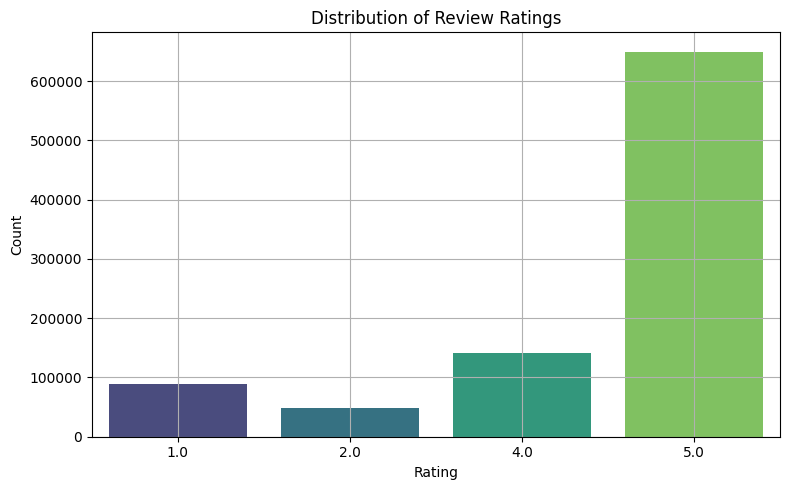

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ratings Distribution Bar Plot
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=reviews_df, palette='viridis')
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


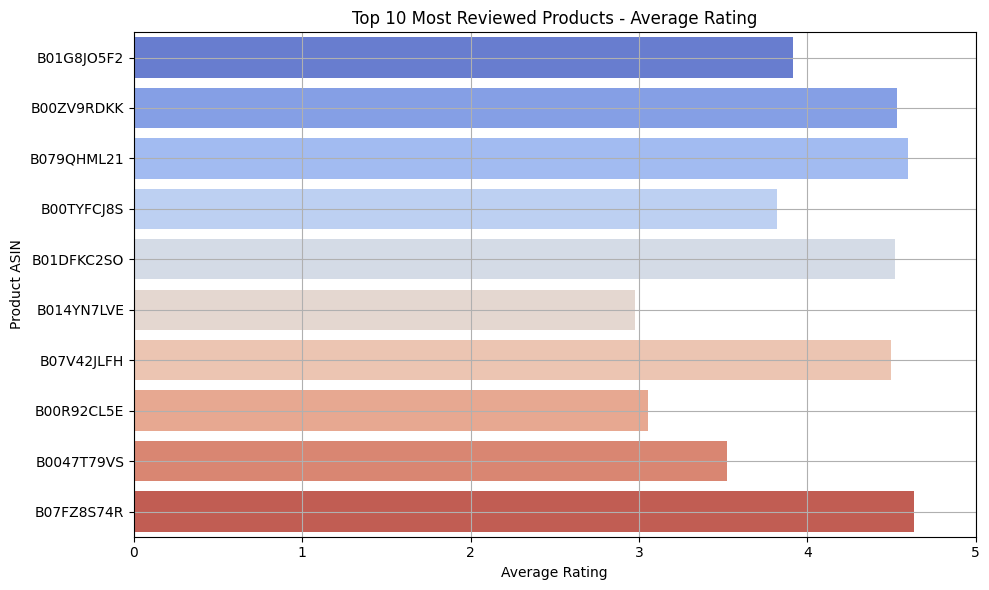

In [18]:
# Get top 10 products by number of reviews and average rating
top_products = (
    reviews_df.groupby('asin')
    .agg(num_reviews=('text', 'count'), avg_rating=('rating', 'mean'))
    .sort_values(by='num_reviews', ascending=False)
    .head(10)
    .reset_index()
)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='asin', data=top_products, palette='coolwarm')
plt.title("Top 10 Most Reviewed Products - Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Product ASIN")
plt.xlim(0, 5)
plt.grid(True)
plt.tight_layout()
plt.show()


# Logistic Regression with TF-IDF

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

X = reviews_df['clean_text'].values
y = reviews_df['label'].values

accuracies = []
fold = 1

def run_log_reg(X, y, vectorizer, model, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        model.fit(X_train_vec, y_train)
        preds = model.predict(X_test_vec)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        scores.append((acc, f1))
        print(f"Fold {fold + 1}: Accuracy={acc:.4f}, F1={f1:.4f}")
        print(classification_report(y_test, preds, digits=3))

    avg_acc = np.mean([s[0] for s in scores])
    print("Avg Accuracy:", avg_acc)
    print("Avg F1 Score:", np.mean([s[1] for s in scores]))
    return avg_acc

## 10 different configs for ablation study

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

configs = [
    {"max_features": 10000},
    {"max_features": 5000},
    {"max_features": 100000},
    {"max_features": 500000},
    {"ngram_range": (1, 2)},
    {"use_idf": False},   
    {"stop_words": None}, 
    {"lowercase": True},
    {"lowercase": False},
    {"max_df": 0.9},
    {"max_features": 10000, "ngram_range": (2, 2)},
]

for i, config in enumerate(configs):
    best_acc = 0
    best_model = None
    print(f"Running Configuration {i+1}: {config}")
    vectorizer = TfidfVectorizer(**config)
    model = LogisticRegression(max_iter=1000)
    acc = run_log_reg(X, y, vectorizer, model)
    if  acc > best_acc:
        best_acc = acc
        best_model = model

Running Configuration 1: {'max_features': 10000}
Fold 1: Accuracy=0.9306, F1=0.9600
              precision    recall  f1-score   support

           0      0.833     0.661     0.737     27348
           1      0.943     0.977     0.960    158330

    accuracy                          0.931    185678
   macro avg      0.888     0.819     0.849    185678
weighted avg      0.927     0.931     0.927    185678

Fold 2: Accuracy=0.9310, F1=0.9603
              precision    recall  f1-score   support

           0      0.836     0.661     0.739     27347
           1      0.944     0.978     0.960    158331

    accuracy                          0.931    185678
   macro avg      0.890     0.819     0.849    185678
weighted avg      0.928     0.931     0.928    185678

Fold 3: Accuracy=0.9302, F1=0.9598
              precision    recall  f1-score   support

           0      0.833     0.659     0.735     27347
           1      0.943     0.977     0.960    158331

    accuracy                

## Extreme Error Analysis

In [24]:
# Transform X to TF-IDF features
X_tfidf = vectorizer.transform(X)

best_model.fit(X_tfidf, y)
preds = best_model.predict(X_tfidf)

# Find the most confident wrong predictions
from sklearn.metrics import confusion_matrix

errors = (preds != y)
probs = best_model.predict_proba(X_tfidf)
conf_scores = np.max(probs, axis=1)

# Most confident incorrect predictions
extreme_errors = np.argsort(-conf_scores[errors])[:10]

for idx in np.where(errors)[0][extreme_errors]:
    print(f"\nTrue: {y[idx]}, Pred: {preds[idx]}, Confidence: {conf_scores[idx]:.2f}")
    print(reviews_df.iloc[idx]['clean_text'])


True: 0, Pred: 1, Confidence: 1.00
work great

True: 0, Pred: 1, Confidence: 1.00
work installed instruction provided broadband work great nothing

True: 0, Pred: 1, Confidence: 1.00
work great ridiculously overpriced piece basic plastic

True: 0, Pred: 1, Confidence: 1.00
work great darn small

True: 0, Pred: 1, Confidence: 1.00
work great constantly dropping phone connecting general

True: 0, Pred: 1, Confidence: 1.00
work great

True: 0, Pred: 1, Confidence: 1.00
work great etc begin fade away well color

True: 0, Pred: 1, Confidence: 1.00
would move jabra work great doesnt cut

True: 0, Pred: 1, Confidence: 1.00
glue work great lol

True: 0, Pred: 1, Confidence: 1.00
product snap back customer unit via fixed tab hinged tab fixed tab thick ca enter notch gps delivered useless ca used deterred shaved thousandth inch tab work great


# RNN with Word2Vec and LSTM

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from gensim.models import Word2Vec
import pickle
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

sentences = [tokens for tokens in reviews_df['tokens'] if len(tokens) > 0]
w2v_model = Word2Vec(sentences=sentences, vector_size=4, min_count=5, workers=4, sg=0, epochs=5)

vocab = w2v_model.wv.key_to_index.copy()
original_vocab_size = len(vocab)
embedding_dim = w2v_model.wv.vector_size
vocab['<PAD>'] = original_vocab_size
vocab['<UNK>'] = original_vocab_size + 1
vocab_size = len(vocab)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [7]:
def text_to_sequence(tokens, vocab, max_length=200):
    sequence = [vocab.get(token, vocab['<UNK>']) for token in tokens[:max_length]]
    sequence += [vocab['<PAD>']] * (max_length - len(sequence))
    return sequence

def prepare_data_tensors(texts, labels, vocab, max_length=200):
    sequences = [text_to_sequence(tokens, vocab, max_length) for tokens in texts]
    X_tensor = torch.tensor(sequences, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return X_tensor, y_tensor

def create_data_loader(X_tensor, y_tensor, batch_size=64, shuffle=True):
    from torch.utils.data import TensorDataset, DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

max_sequence_length = 200
X_tokens = reviews_df['tokens'].values
y_labels = reviews_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X_tokens, y_labels, test_size=0.2, random_state=42, stratify=y_labels)
X_train_tensor, y_train_tensor = prepare_data_tensors(X_train, y_train, vocab, max_sequence_length)
X_test_tensor, y_test_tensor = prepare_data_tensors(X_test, y_test, vocab, max_sequence_length)
batch_size = 64
train_loader = create_data_loader(X_train_tensor, y_train_tensor, batch_size=batch_size, shuffle=True)
test_loader = create_data_loader(X_test_tensor, y_test_tensor, batch_size=batch_size, shuffle=False)
print(f"Train loader size: {len(train_loader)}, Test loader size: {len(test_loader)}")

Train loader size: 11605, Test loader size: 2902


In [8]:
class RNNLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 num_layers=2, dropout=0.3, embedding_matrix=None):
        super(RNNLSTMClassifier, self).__init__()
        
        # Use pre-trained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True  # Fine-tune embeddings
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Apply attention
        attention_weights = torch.tanh(self.attention(lstm_out))
        attention_weights = torch.softmax(attention_weights, dim=1)
        attended_output = torch.sum(attention_weights * lstm_out, dim=1)
        
        attended_output = self.dropout(attended_output)
        
        output = self.relu(self.fc1(attended_output))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output


# Initialize model
model = RNNLSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=64,
    num_layers=1,
    dropout=0.3,
    embedding_matrix=embedding_matrix
).to(device)

# Print model summary
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Architecture:
RNNLSTMClassifier(
  (embedding): Embedding(32035, 4)
  (lstm): LSTM(4, 64, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)

Total parameters: 172,495


In [9]:
# Training and evaluation functions
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for _, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy, all_preds, all_targets

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [10]:
# Training loop
num_epochs = 4
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step()
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1
Train Loss: 0.2199, Train Acc: 91.41%
Val Loss: 0.1773, Val Acc: 92.98%
Learning Rate: 0.001000
Epoch 2
Train Loss: 0.1757, Train Acc: 93.14%
Val Loss: 0.1669, Val Acc: 93.48%
Learning Rate: 0.001000
Epoch 3
Train Loss: 0.1707, Train Acc: 93.37%
Val Loss: 0.1684, Val Acc: 93.35%
Learning Rate: 0.001000
Epoch 4
Train Loss: 0.1674, Train Acc: 93.46%
Val Loss: 0.1682, Val Acc: 93.45%
Learning Rate: 0.001000
